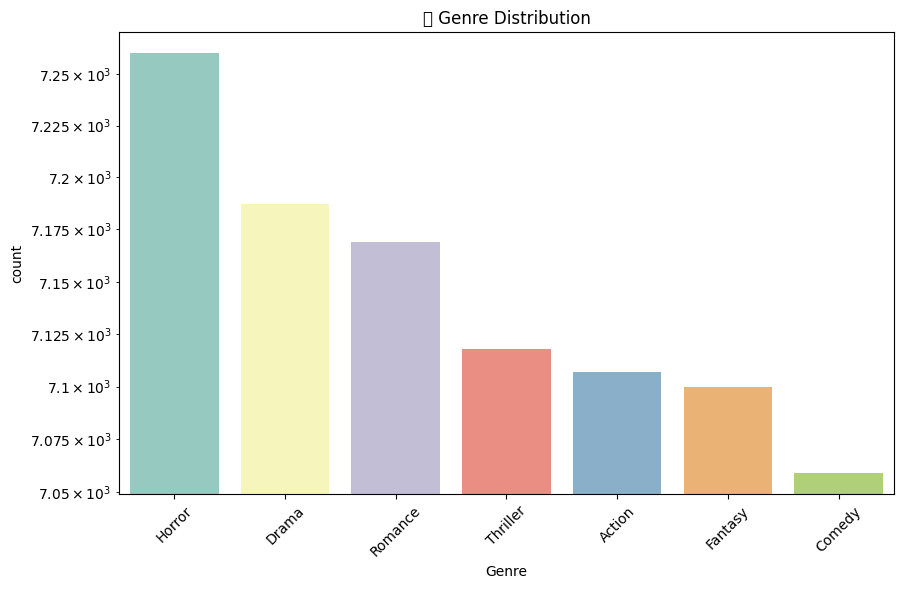

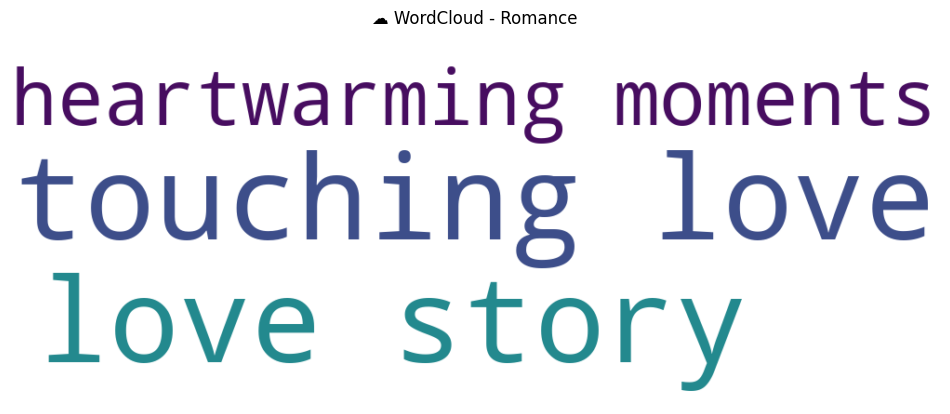

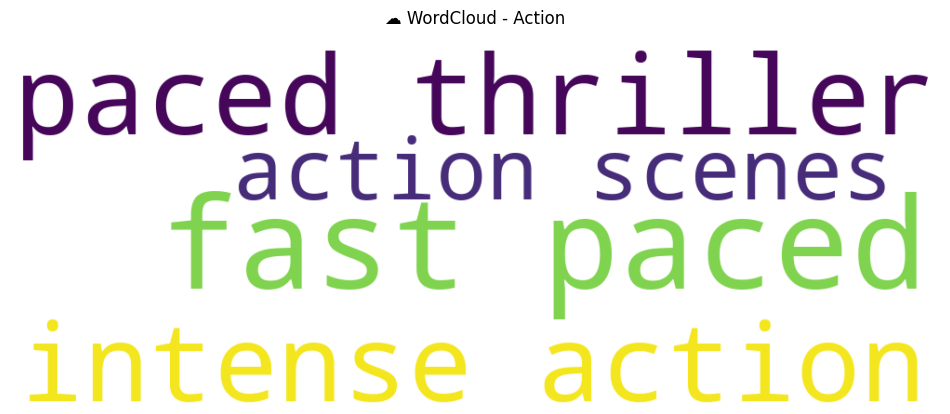

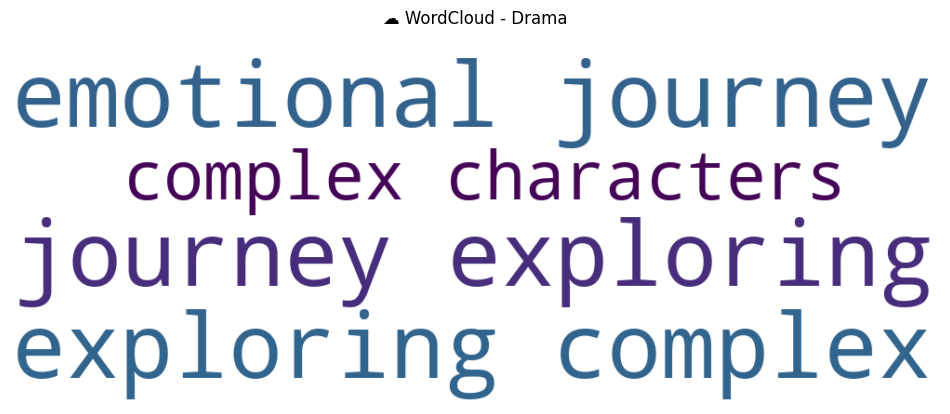

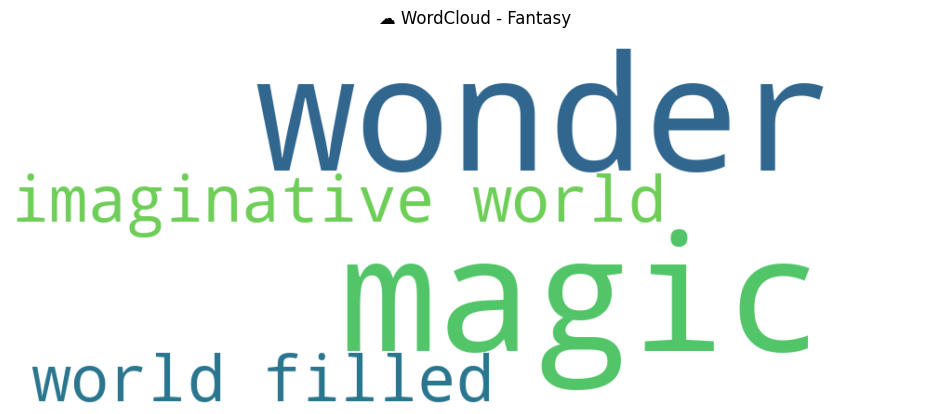

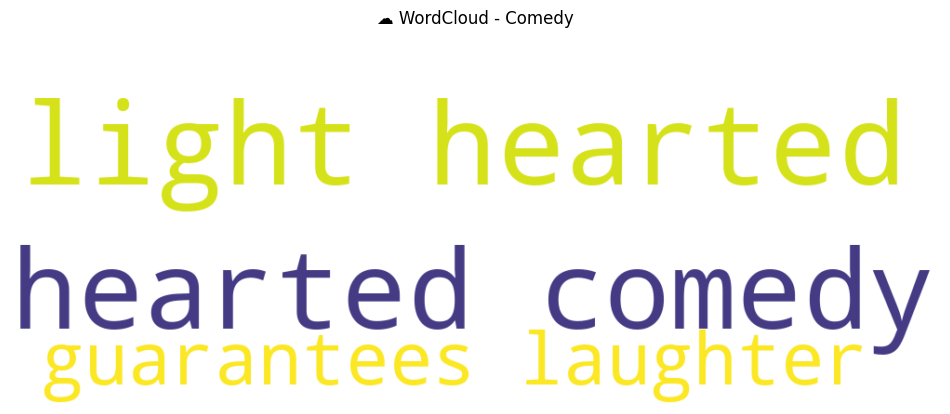

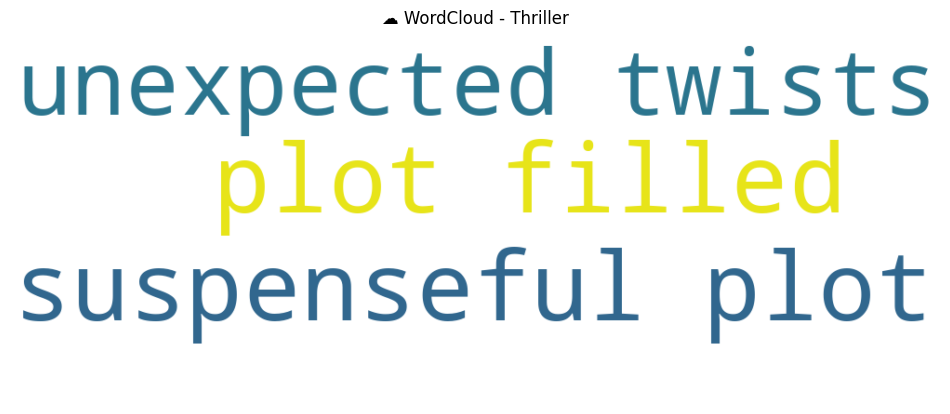

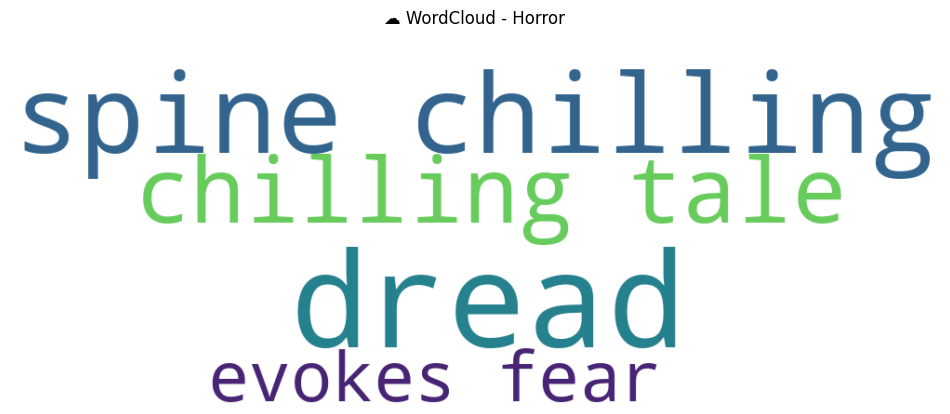

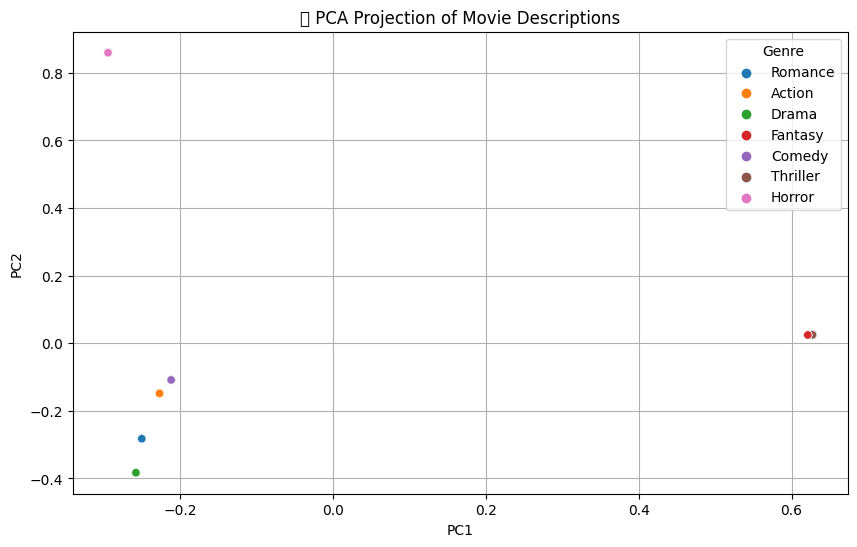

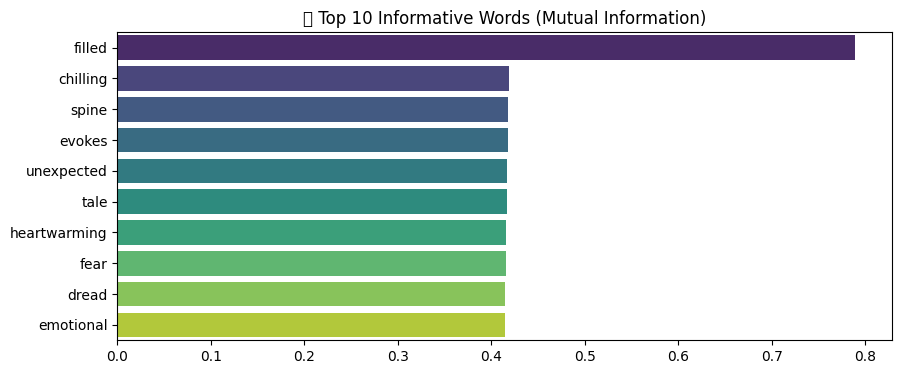


✅ Top 20 Results:
          Encoding            Balancer        Scaler Reducer  \
30   LabelEncoding           NoBalance  MinMaxScaler     PCA   
308  LabelEncoding               SMOTE  MinMaxScaler     PCA   
311  LabelEncoding               SMOTE  MinMaxScaler     LDA   
309  LabelEncoding               SMOTE  MinMaxScaler     PCA   
300  LabelEncoding               SMOTE  MinMaxScaler     PCA   
131  LabelEncoding   RandomOverSampler  MinMaxScaler     LDA   
135  LabelEncoding   RandomOverSampler  MinMaxScaler     LDA   
132  LabelEncoding   RandomOverSampler  MinMaxScaler     LDA   
133  LabelEncoding   RandomOverSampler  MinMaxScaler     LDA   
134  LabelEncoding   RandomOverSampler  MinMaxScaler     LDA   
303  LabelEncoding               SMOTE  MinMaxScaler     PCA   
302  LabelEncoding               SMOTE  MinMaxScaler     PCA   
49   LabelEncoding           NoBalance  MinMaxScaler     LDA   
137  LabelEncoding   RandomOverSampler  MinMaxScaler     LDA   
213  LabelEncoding  R

In [1]:
# ==============================
# 1. import libraries 
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

# ==============================
# 2. Load the data
# ==============================
df = pd.read_csv("/kaggle/input/movie-genre-classification/movie_genre_classification_final.csv")
df['Description'] = df['Description'].astype(str)
imputer = SimpleImputer(strategy='most_frequent')
df[df.columns] = imputer.fit_transform(df)

# ==============================
# 3. 🔍 Advanced EDA
# ==============================

plt.figure(figsize=(10,6))
sns.countplot(x='Genre', data=df, order=df['Genre'].value_counts().index, palette='Set3')
plt.title('🎯 Genre Distribution')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

for genre in df['Genre'].unique():
    text = " ".join(df[df['Genre'] == genre]['Description'])
    wc = WordCloud(width=1000, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"☁️ WordCloud - {genre}")
    plt.show()

# TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['Description'])

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Genre"] = df["Genre"]
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Genre", palette="tab10", alpha=0.7)
plt.title("📌 PCA Projection of Movie Descriptions")
plt.grid(True)
plt.show()

# Top informative words
y_mi = LabelEncoder().fit_transform(df['Genre'])
mi = mutual_info_classif(X_tfidf.toarray(), y_mi)
top_words = np.array(tfidf.get_feature_names_out())[np.argsort(mi)[-10:][::-1]]
top_scores = np.sort(mi)[-10:][::-1]
plt.figure(figsize=(10,4))
sns.barplot(x=top_scores, y=top_words, palette="viridis")
plt.title("🧠 Top 10 Informative Words (Mutual Information)")
plt.show()

# Boxen & KDE Plots
num_cols = ['rating', 'duration', 'release_year']
for col in num_cols:
    if col in df.columns:
        plt.figure(figsize=(10,5))
        sns.violinplot(data=df, x="Genre", y=col, palette="pastel")
        plt.title(f"🎻 {col} by Genre")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.show()

# ==============================
# 4. Machine Learning Classification
# ==============================
target_column = "Genre"
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

def apply_label_encoding(df):
    df_encoded = df.copy()
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = le.fit_transform(df_encoded[col])
    return df_encoded

encodings = {
    "LabelEncoding": apply_label_encoding,
}

balancers = {
    "NoBalance": None,
    "RandomOverSampler": RandomOverSampler(),
    "RandomUnderSampler": RandomUnderSampler(),
    "SMOTE": SMOTE()
}

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

reducers = {
    "PCA": PCA(n_components=5),
    "LDA": LDA(n_components=1),
    "TruncatedSVD": TruncatedSVD(n_components=5)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "NaiveBayes": GaussianNB(),
    "GradientBoosting": GradientBoostingClassifier(),
    "MLP": MLPClassifier(max_iter=500),
    "ExtraTree": RandomForestClassifier(n_estimators=100)
}

results = []
for enc_name, enc_func in encodings.items():
    try:
        df_enc = enc_func(df)
        X = df_enc.drop(target_column, axis=1)
        y = df_enc[target_column]
    except Exception as e:
        print(f"⚠️ Encoding Error {enc_name}: {e}")
        continue

    for bal_name, balancer in balancers.items():
        try:
            X_bal, y_bal = (X, y) if balancer is None else balancer.fit_resample(X, y)
        except Exception as e:
            print(f"⚠️ Balancing Error {bal_name}: {e}")
            continue

        for scaler_name, scaler in scalers.items():
            try:
                X_scaled = scaler.fit_transform(X_bal)
            except Exception as e:
                print(f"⚠️ Scaling Error {scaler_name}: {e}")
                continue

            for reducer_name, reducer in reducers.items():
                try:
                    if reducer_name == 'LDA':
                        if len(np.unique(y_bal)) < 2:
                            continue
                        X_red = reducer.fit_transform(X_scaled, y_bal)
                    else:
                        X_red = reducer.fit_transform(X_scaled)
                except Exception as e:
                    print(f"⚠️ Reduction Error {reducer_name}: {e}")
                    continue

                try:
                    X_train, X_test, y_train, y_test = train_test_split(X_red, y_bal, test_size=0.2, random_state=42)
                except Exception as e:
                    print(f"⚠️ Split Error: {e}")
                    continue

                for model_name, model in models.items():
                    try:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        acc = accuracy_score(y_test, y_pred)
                        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

                        results.append({
                            "Encoding": enc_name,
                            "Balancer": bal_name,
                            "Scaler": scaler_name,
                            "Reducer": reducer_name,
                            "Model": model_name,
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1-Score": f1
                        })
                    except Exception as e:
                        print(f"⚠️ Model Error {model_name}: {e}")
                        continue

# ==============================
# 5. Save Results
# ==============================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-Score", ascending=False)
print("\n✅ Top 20 Results:")
print(results_df.head(20))
results_df.to_csv("ml_results_summary.csv", index=False)
print("✅ Results saved to ml_results_summary.csv")


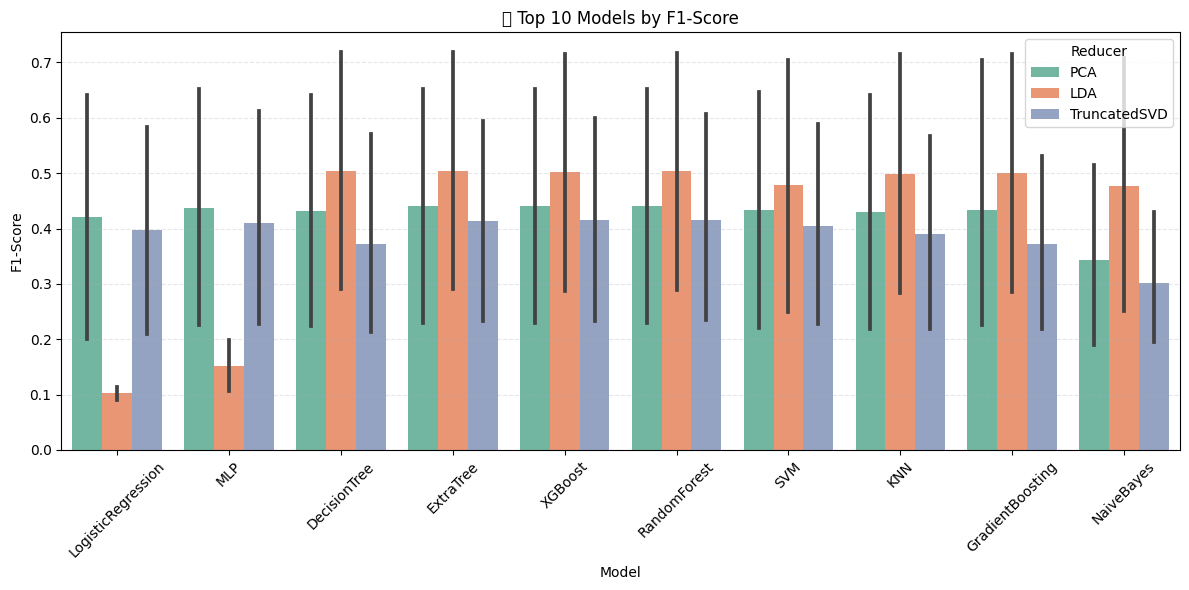

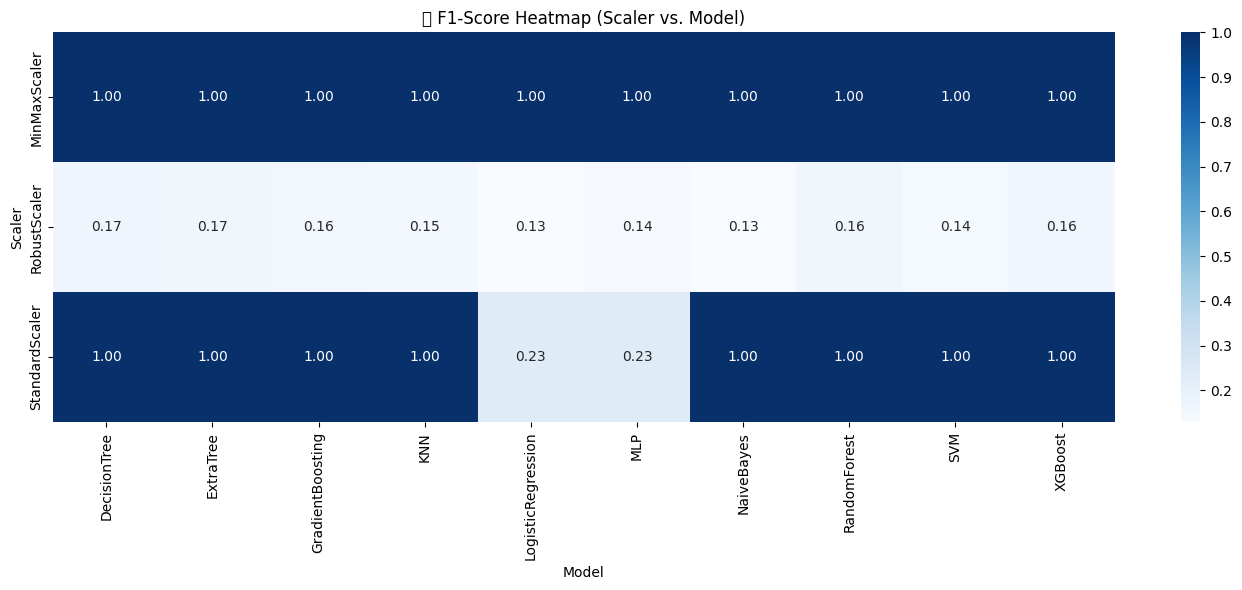

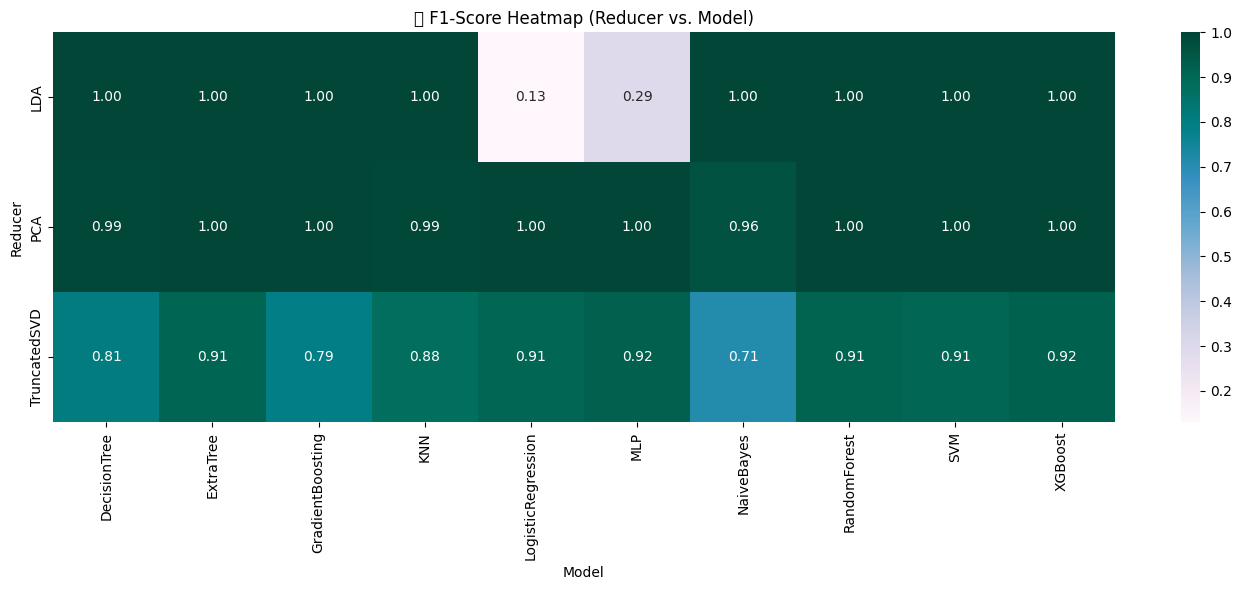

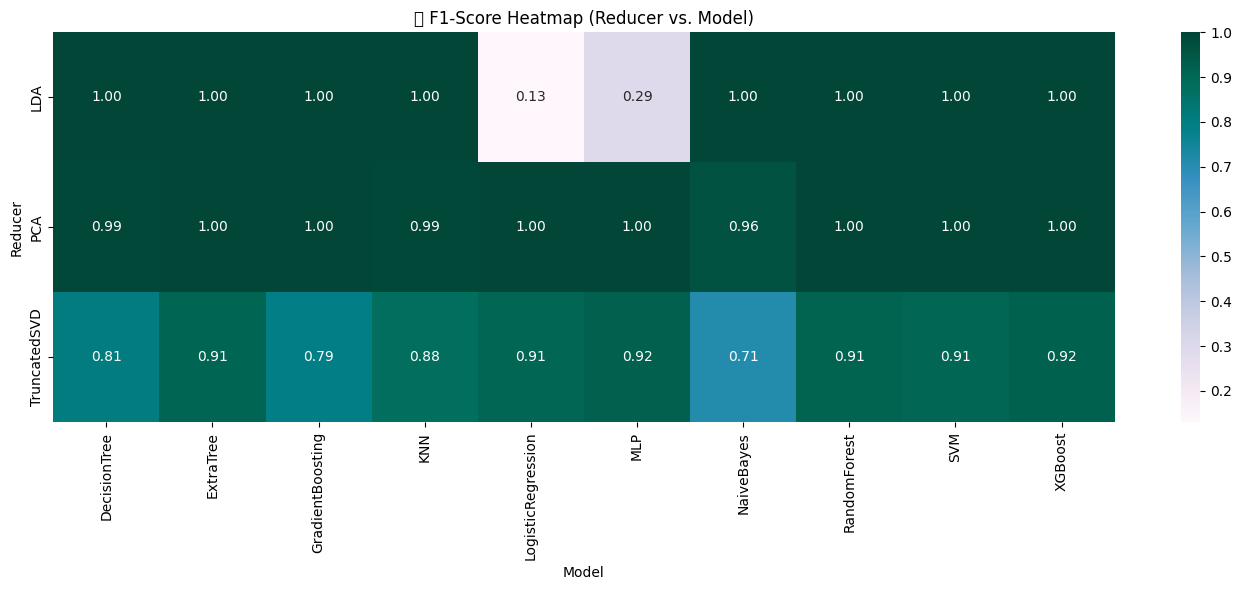

In [10]:
# ==============================
# 6. Visualize Results
# ==============================

results = results_df

# 🔹 Barplot of  models by F1-Score
plt.figure(figsize=(12,6))
sns.barplot(data=results, x="Model", y="F1-Score", hue="Reducer", palette="Set2")
plt.title("🏆 Top 10 Models by F1-Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 🔹 Heatmap of F1-Score by Scaler vs. Model
pivot_scaler_model = results_df.pivot_table(values='F1-Score', index='Scaler', columns='Model', aggfunc='max')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_scaler_model, annot=True, fmt=".2f", cmap="Blues")
plt.title("🔥 F1-Score Heatmap (Scaler vs. Model)")
plt.tight_layout()
plt.show()

# 🔹 Heatmap of F1-Score by Reducer vs. Model
pivot_reducer_model = results_df.pivot_table(values='F1-Score', index='Reducer', columns='Model', aggfunc='max')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_reducer_model, annot=True, fmt=".2f", cmap="PuBuGn")
plt.title("🔥 F1-Score Heatmap (Reducer vs. Model)")
plt.tight_layout()
plt.show()
# 🔹 Heatmap of F1-Score by Reducer vs. Model
pivot_reducer_model = results_df.pivot_table(values='F1-Score', index='Reducer', columns='Model', aggfunc='max')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_reducer_model, annot=True, fmt=".2f", cmap="PuBuGn")
plt.title("🔥 F1-Score Heatmap (Reducer vs. Model)")
plt.tight_layout()
plt.show()


# 🔹 Interactive Plotly Scatter (Precision vs Recall vs F1)
fig = px.scatter(
    results_df, x="Precision", y="Recall", size="F1-Score", color="Model",
    hover_data=["Encoding", "Scaler", "Reducer", "Balancer"],
    title="📈 Model Performance: Precision vs Recall vs F1-Score"
)
fig.show()
